In [2]:
from tqdm import tqdm
import torch
import pandas as pd

In [3]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [4]:
# Load queries from file
queries = []
with open("data/US/queries.txt", "r") as f:
    for line in f:
        queries.append(line.strip())

In [5]:
queries[578]

'flu jabs'

# First filter: only allow queries with sufficient data

In [6]:
with open('./data/US/queries_filtered.txt') as f:
    raw_us_queries = f.read().splitlines()
query_ids = set([int(r.split('\t')[0]) for r in raw_us_queries])
q_freq_us_raw = pd.read_csv('./data/US/Q_freq.csv')

from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days

def day_index(d):
    return days_between('2004-01-01', d)

# Second filter: semantic filter

In [7]:
# Encode queries
batch_size = 128
embeddings = torch.tensor([])
for i in tqdm(range(0, len(queries), batch_size)):
    batch = queries[i : i + batch_size]
    embeddings = torch.cat((embeddings, torch.tensor(model.encode(batch))))

# Save embeddings
torch.save(embeddings, "data/US/queries_embeddings.pt")

100%|██████████| 177/177 [00:08<00:00, 19.90it/s]


In [8]:
def cosine_similarity(a, b):
    # Both are torch tensors
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

In [9]:
# Flu concept embeddings
flu_embedding = torch.tensor(model.encode("flu"))
fever_embedding = torch.tensor(model.encode("fever"))

# Negative control concept embeddings
vaccine_embedding = torch.tensor(model.encode("vaccine"))
cold_flu_embedding = torch.tensor(model.encode("cold"))

query_similarities = []
for i, query in enumerate(queries):
    query_id = i + 1
    query_embedding = embeddings[i]
    flu_symptom_similarity = cosine_similarity(query_embedding, flu_embedding)
    flu_vaccine_similarity = cosine_similarity(query_embedding, fever_embedding)
    vaccine_embedding_similarity = cosine_similarity(query_embedding, vaccine_embedding)
    cold_flu_embedding_similarity = cosine_similarity(query_embedding, cold_flu_embedding)
    # Average of the three similarities
    average_similarity = flu_symptom_similarity + flu_vaccine_similarity
    query_similarities.append((query_id, query, average_similarity.item()))

# Sort queries by similarity
query_similarities.sort(key=lambda x: x[2], reverse=True)

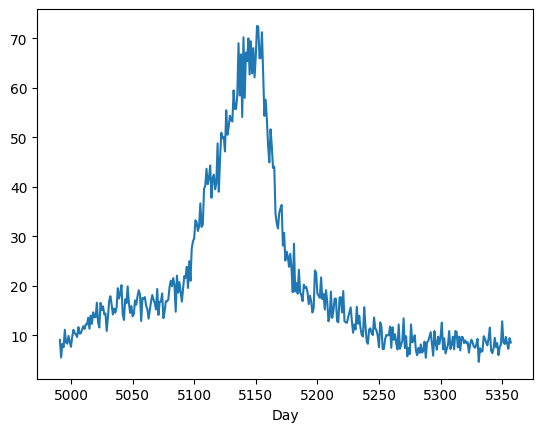

In [10]:
# Sort all queries by similarity with vaccine

word_embedding = torch.tensor(model.encode("flu pain"))

query_similarities_vaccine = []
for i, query in enumerate(queries):
    query_id = i + 1
    query_embedding = embeddings[i]
    vaccine_embedding_similarity = cosine_similarity(query_embedding, word_embedding)
    query_similarities_vaccine.append((query_id, query, vaccine_embedding_similarity.item()))

query_similarities_vaccine.sort(key=lambda x: x[2], reverse=True)

# Find the top 10 queries
top_10_queries = query_similarities_vaccine[:10]

# Plot freq of these queries
import matplotlib.pyplot as plt
import numpy as np

top_10_query_ids = [q[0] for q in top_10_queries]

top_10_query_freq = q_freq_us_raw[q_freq_us_raw['Query'].isin(top_10_query_ids)]
top_10_query_freq = top_10_query_freq.pivot(index='Day', columns='Query', values='Frequency')
top_10_query_freq = top_10_query_freq.fillna(0)

# Filter out last 4 years
top_10_query_freq = top_10_query_freq.loc[day_index('2017-08-31'):day_index('2018-09-01')]

top_10_query_freq.mean(axis=1).plot()
plt.show()

In [11]:
q_freq_us_raw

,Day,Query,Frequency
0,0,19124,620.665849
1,0,19306,937.115728
2,0,19393,981.208003
3,0,19794,617.952412
4,0,20148,730.450502
...,...,...,...
87137909,7172,21466,8.860902
87137910,7172,21469,6.276061
87137911,7172,21472,5.168762
87137912,7172,21473,5.427533


In [13]:
# Filter out queries with qids_with_data
filtered_queries = []
for query in query_similarities:
    filtered_queries.append(query)

# Remove queries with the word cold
filtered_queries = [query for query in filtered_queries if "cold" not in query[1].lower()]

# Only use first 1500 queries
filtered_queries = filtered_queries[:1500]

# Save filtered queries
with open("data/England/queries_filtered.txt", "w") as f:
    for query in filtered_queries:
        f.write(f"{query[0]}\t{query[1]}\n")